In [296]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, model_max, addvars, addvals
from ortoolpy import logistics_network
import networkx as nx

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# 7章 ロジスティクスネットワークの最適設計を行う10本ノック

ここでは、最適化計算を行ういくつかのライブラリを用いて、最適化計算を実際に行う。  
そして、6章で用いたネットワーク可視化などの技術を駆使し、計算結果の妥当性を確認する方法についても学ぶ。

- ロジスティクス・ネットワーク（物流ネットワーク）
  - 最終的に製品を販売する小売店（商店P, Q）がある
  - 小売店で販売される製品群（製品A, B）には、一定の需要がある
  - 各需要量に基づいて工場（工場X, Y）での生産量は決められる
  - それぞれの製品をどの工場のどのライン（レーン0, 1）で製造するかについては、
    - 各工場から小売店への輸送費、製造コストなどを加味して決められる

### Knock61: 輸送最適化問題を解く

In [297]:
# データ読み込み

df_tc = pd.read_csv("../support/7章/trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("../support/7章/demand.csv")
df_supply = pd.read_csv("../support/7章/supply.csv")

display(df_tc)
display(df_demand)
display(df_supply)

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [298]:
# 初期設定

np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))
print(range(nw))
print(range(nf))
print(pr)

range(0, 3)
range(0, 4)
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [299]:
# 数理モデルの作成

# 「最小化を行う」モデルを定義
m1 = model_min()

# 工場と倉庫の組み合わせの変数
v1 = {
    (i, j): LpVariable("v%d_%d"%(i, j), lowBound=0) for i, j in pr
}
"""
v1
{
    (0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, 
    (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, 
    (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3
}
"""

# 目的関数の定式化
m1 += lpSum(df_tc.iloc[i][j] * v1[i, j] for i, j in pr)
"""
m1
NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous
"""

'\nm1\nNoName:\nMINIMIZE\n10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0\nVARIABLES\nv0_0 Continuous\nv0_1 Continuous\nv0_2 Continuous\nv0_3 Continuous\nv1_0 Continuous\nv1_1 Continuous\nv1_2 Continuous\nv1_3 Continuous\nv2_0 Continuous\nv2_1 Continuous\nv2_2 Continuous\nv2_3 Continuous\n'

In [300]:
# 工場の制約条件
# 工場の製造する製品が需要を満たすようにする
for i in range(nw):
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]

# 倉庫の制約条件
# 倉庫の供給する部品が供給限界を超過しないようにする
for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]

In [301]:
# 最適化問題をsolveによって解く

m1.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/python-practical-data-analysis-100knocks/venv/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/831268cfed07478fb618af387e4b9b30-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/831268cfed07478fb618af387e4b9b30-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 49 RHS
At line 57 BOUNDS
At line 58 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 12 (0) columns and 24 (0) elements
0  Obj 0 Primal inf 113 (4)
7  Obj 1296
Optimal - objective value 1296
Optimal objective 1296 - 7 iterations time 0.002
Option for printingOptions changed from normal to all


1

In [302]:
# 総輸送コスト計算

df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j] * value(x)

print(df_tr_sol)
print(f"総輸送コスト: {total_cost} 万円")

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト: 1296.0 万円


### Knock62: 最適輸送ルートをネットワークで確認する

In [303]:
# 最適輸送ルートをネットワーク可視化

# データの読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv("../support/7章/trans_route_pos.csv")

display(df_tr)
display(df_pos)

,F1,F2,F3,F4
工場,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0000,4.0000,4.0000,4.0000
1,1,2,3,0.5000,1.5000,2.5000,3.5000


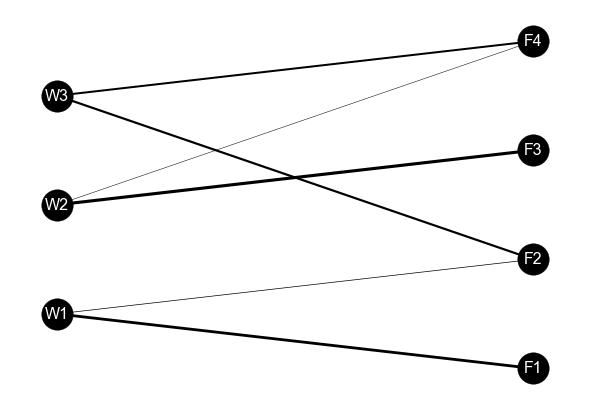

In [304]:
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定とエッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i == j):
            # 辺の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # エッジの重みの追加
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size

                edge_weights.append(weight)

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

# 描画
nx.draw(
    G, pos, with_labels=True,
    font_size=16, font_color="w",
    node_size=1000, node_color="k",
    width=edge_weights
)

# 表示
plt.show()

In [305]:
print(G.edges, len(G.edges))
print(edge_weights, len(edge_weights))

[('W1', 'W2'), ('W1', 'W3'), ('W1', 'F1'), ('W1', 'F2'), ('W1', 'F3'), ('W1', 'F4'), ('W2', 'W3'), ('W2', 'F1'), ('W2', 'F2'), ('W2', 'F3'), ('W2', 'F4'), ('W3', 'F1'), ('W3', 'F2'), ('W3', 'F3'), ('W3', 'F4'), ('F1', 'F2'), ('F1', 'F3'), ('F1', 'F4'), ('F2', 'F3'), ('F2', 'F4'), ('F3', 'F4')] 21
[0, 0, 2.8000000000000003, 0.7000000000000001, 0, 0, 0, 0, 0, 3.1, 0.5, 0, 2.2, 0, 2.0, 0, 0, 0, 0, 0, 0] 21


### Knock63: 最適輸送ルートが制約条件内に収まっているか確認する

In [306]:
# データの読み込み

# 需要量
df_demand = pd.read_csv("../support/7章/demand.csv")
# 供給限界
df_supply = pd.read_csv("../support/7章/supply.csv")

display(df_demand)
display(df_supply)

,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [307]:
# 制約条件計算関数

# 需要側（工場）
def condition_demand(df_tr: pd.DataFrame, df_demand: pd.DataFrame):
    """要求されている需要量を満たしているかを確認する"""
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1

    return flag

# 供給側（倉庫）
def condition_supply(df_tr: pd.DataFrame, df_supply: pd.DataFrame):
    """供給限界量超えていないかを確認する"""
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if (temp_sum <= df_supply.iloc[0][i]):
            flag[i] = 1

    return flag

In [308]:
# 新しい輸送ルートが制約条件を満たしているかの確認

print(f"需要条件計算結果: {condition_demand(df_tr_sol, df_demand)}")
print(f"供給条件計算結果: {condition_supply(df_tr_sol, df_supply)}")

需要条件計算結果: [1. 1. 1. 1.]
供給条件計算結果: [1. 1. 1.]


### Knock64: 生産計画に関するデータを読み込む

- 生産計画データ一覧
  - product_plan_material.csv（製品の製造に必要な原料の割合）
  - product_plan_profit.csv（製品の利益）
  - product_plan_stock.csv（原料の在庫）
  - product_plan.csv（製品の生産量）

In [309]:
# 生産計画データの読み込み

# 製品の製造に必要な原料の割合
df_material = pd.read_csv("../support/7章/product_plan_material.csv", index_col="製品")
print("製品の製造に必要な原料の割合（material）")
display(df_material)

# 製品の利益
df_profit = pd.read_csv("../support/7章/product_plan_profit.csv", index_col="製品")
print("製品の利益（profit）")
display(df_profit)

# 原料の在庫
df_stock = pd.read_csv("../support/7章/product_plan_stock.csv", index_col="項目")
print("原料の在庫（stock）")
display(df_stock)

# 製品の生産量
df_plan = pd.read_csv("../support/7章/product_plan.csv", index_col="製品")
print("製品の生産量（plan）")
display(df_plan)

製品の製造に必要な原料の割合（material）


,原料1,原料2,原料3
製品,,,
製品1,1,4,3
製品2,2,4,1


製品の利益（profit）


,利益
製品,
製品1,5.0000
製品2,4.0000


原料の在庫（stock）


,原料1,原料2,原料3
項目,,,
在庫,40,80,50


製品の生産量（plan）


,生産量
製品,
製品1,16
製品2,0


### Knock65: 利益を計算する関数を作る

- 生産計画の最適化（生産最適化）

In [310]:
# 利益計算関数

def product_plan(df_profit: pd.DataFrame, df_plan: pd.DataFrame):
    """
    利益を計算する関数
    各製品の利益と製造量の積の和
    """
    profit = 0
    for i in range(len(df_profit.index)):  # "製品1", "製品2"
        for j in range(len(df_plan.columns)):  # "生産量"
            profit += df_profit.iloc[i][j] * df_plan.iloc[i][j]
    return profit

In [311]:
# 総利益の計算

print(f"総利益: {product_plan(df_profit, df_plan)}")

総利益: 80.0


### Knock66: 生産最適化問題を解く

- 目的関数（利益関数）を最大化することを目的として、最適化計算を行う

In [312]:
# 目的関数（利益関数）を最大化する最適化計算

# 数理モデル（最大化）作成
m = model_max()
print(m)

NoName:
MAXIMIZE
None
VARIABLES



In [313]:
# 製品数と同じ次元数の変数を定義
v1 = {
    (i): LpVariable("v%d" % (i), lowBound=0) for i in range(len(df_profit))
}
print(len(v1))
print(v1)

2
{0: v0, 1: v1}


In [314]:
# 目的変数の定義
m += lpSum(df_profit.iloc[i] * v1[i] for i in range(len(df_profit)))
print(m)

NoName:
MAXIMIZE
5.0*v0 + 4.0*v1 + 0.0
VARIABLES
v0 Continuous
v1 Continuous



In [315]:
# 制約条件の定義
for i in range(len(df_material.columns)):
    m += lpSum(
        df_material.iloc[j, i] * v1[j] for j in range(len(df_profit))
    ) <= df_stock.iloc[:, i]
    
print(m)

NoName:
MAXIMIZE
5.0*v0 + 4.0*v1 + 0.0
SUBJECT TO
_C1: v0 + 2 v1 <= 40

_C2: 4 v0 + 4 v1 <= 80

_C3: 3 v0 + v1 <= 50

VARIABLES
v0 Continuous
v1 Continuous



In [316]:
# solveによる最適化
m.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/python-practical-data-analysis-100knocks/venv/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/596882bf3f5d4632bf829c37bdce98d6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/cm/w7d5zwgj0h3gp9q0lvvq4yrr0000gn/T/596882bf3f5d4632bf829c37bdce98d6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj -0 Dual inf 8.9999998 (2)
0  Obj -0 Dual inf 8.9999998 (2)
2  Obj 95
Optimal - objective value 95
Optimal objective 95 - 2 iterations time 0.002
Option for printingOpti

1

In [317]:
print(v1.items())

dict_items([(0, v0), (1, v1)])


In [318]:
df_plan_sol = df_plan.copy()
display(df_plan_sol)

,生産量
製品,
製品1,16
製品2,0


In [319]:

for k, x in v1.items():
    print(value(x))
    df_plan_sol.iloc[k] = value(x)

display(df_plan_sol)

15.0
5.0


,生産量
製品,
製品1,15
製品2,5


In [320]:
print(f"総利益: {value(m.objective)}")

総利益: 95.0


### Knock67: 最適生産計画が制約条件内に収まっているか確認する

In [321]:
# 制約条件計算関数

def condition_stock(df_plan: pd.DataFrame, df_material: pd.DataFrame, df_stock: pd.DataFrame):
    """制約条件に収まっているか確認する"""
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            # 使用量の計算
            temp_sum += df_material.iloc[j][i] * float(df_plan.iloc[j])
        # 使用量と在庫の比較
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(f"{df_material.columns[i]} 使用量: {temp_sum}, 在庫: {float(df_stock.iloc[0][i])}")

    return flag

In [322]:
print(f"制約条件計算結果: {condition_stock(df_plan, df_material, df_stock)}")

原料1 使用量: 16.0, 在庫: 40.0
原料2 使用量: 64.0, 在庫: 80.0
原料3 使用量: 48.0, 在庫: 50.0
制約条件計算結果: [1. 1. 1.]


### Knock68: ロジスティクス・ネットワーク設計問題を解く

In [323]:
# ロジスティクス・ネットワーク

# 各拠点
products = list('AB')
stores = list('PQ')
factories = list('XY')
lanes = (2, 2)

# 輸送費
shipping_cost_table = pd.DataFrame(
    ((j, k) for j in stores for k in factories),
    columns=["需要地", "工場"]
)
shipping_cost_table["輸送費"] = [1, 2, 3, 1]
display(shipping_cost_table)

# 需要
demand_table = pd.DataFrame(
    ((j, i) for j in stores for i in products),
    columns=["需要地", "製品"]
)
demand_table["需要"] = [10, 10, 20, 30]
display(demand_table)

# 生産
production_table = pd.DataFrame(
    ((k, l, i, 0, np.inf) for k, nl in zip (factories, lanes) for l in range(nl) for i in products),
    columns=["工場", "レーン", "製品", "下限", "上限"]
)
production_table["生産費"] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
production_table.dropna(inplace=True)
production_table.loc[4, "上限"] = 10
display(production_table)

,需要地,工場,輸送費
0,P,X,1
1,P,Y,2
2,Q,X,3
3,Q,Y,1


,需要地,製品,需要
0,P,A,10
1,P,B,10
2,Q,A,20
3,Q,B,30


,工場,レーン,製品,下限,上限,生産費
0,X,0,A,0,inf,1.0000
3,X,1,B,0,inf,1.0000
4,Y,0,A,0,10.0000,3.0000
6,Y,1,A,0,inf,5.0000
7,Y,1,B,0,inf,3.0000


In [324]:
_, shipping_cost_table2, _ = logistics_network(demand_table, shipping_cost_table, production_table)

display(production_table)
display(shipping_cost_table2)

,工場,レーン,製品,下限,上限,生産費,VarY,ValY
0,X,0,A,0,inf,1.0000,v000087,20.0000
3,X,1,B,0,inf,1.0000,v000088,10.0000
4,Y,0,A,0,10.0000,3.0000,v000089,10.0000
6,Y,1,A,0,inf,5.0000,v000090,0.0000
7,Y,1,B,0,inf,3.0000,v000091,30.0000


,需要地,工場,輸送費,製品,VarX,ValX
0,P,X,1,A,v000079,10.0000
1,P,X,1,B,v000080,10.0000
2,Q,X,3,A,v000081,10.0000
3,Q,X,3,B,v000082,0.0000
4,P,Y,2,A,v000083,0.0000
5,P,Y,2,B,v000084,0.0000
6,Q,Y,1,A,v000085,10.0000
7,Q,Y,1,B,v000086,30.0000


### Knock69: 最適ネットワークにおける輸送コストとその内訳を計算する

In [325]:
# 輸送コストの計算

display(shipping_cost_table2)
trans_cost = 0
for i in range(len(shipping_cost_table2.index)):
    trans_cost += shipping_cost_table2["輸送費"].iloc[i] * shipping_cost_table2["ValX"].iloc[i]

print(f"総輸送コスト: {trans_cost}")

,需要地,工場,輸送費,製品,VarX,ValX
0,P,X,1,A,v000079,10.0000
1,P,X,1,B,v000080,10.0000
2,Q,X,3,A,v000081,10.0000
3,Q,X,3,B,v000082,0.0000
4,P,Y,2,A,v000083,0.0000
5,P,Y,2,B,v000084,0.0000
6,Q,Y,1,A,v000085,10.0000
7,Q,Y,1,B,v000086,30.0000


総輸送コスト: 90.0


### Knock70: 最適ネットワークにおける生産コストとその内訳を計算する

In [326]:
# 生産コストの計算

display(production_table)
product_cost = 0
for i in range(len(production_table.index)):
    product_cost += production_table["生産費"].iloc[i] * production_table["ValY"].iloc[i]

print(f"総生産コスト: {product_cost}")

,工場,レーン,製品,下限,上限,生産費,VarY,ValY
0,X,0,A,0,inf,1.0000,v000087,20.0000
3,X,1,B,0,inf,1.0000,v000088,10.0000
4,Y,0,A,0,10.0000,3.0000,v000089,10.0000
6,Y,1,A,0,inf,5.0000,v000090,0.0000
7,Y,1,B,0,inf,3.0000,v000091,30.0000


総生産コスト: 150.0
